## 007 Pilot RL-craving joint sequential models in pymc (single subject)

Date: 23.Jul.2022

### Purpose

Implement RW-craving sequential models

### Outline of Plan

1. Rerun RW model for subject 7
2. Implement RW-craving model to fit craving ratings sequentially in addition to decision modeling
3. Compare model performance (can we compare on the same scale?)

### What we did in this notebook

1. RW model obtained from prolific-food-craving/derivatives/joint/exploration/1_refactored_model_comparison.ipynb
2. Fit the RW model to subject 7 data
3. Implemented the JointSeqRW model, calculates the predicted Qs, PEs, and cravings
4. Having two observed vectors (task choices and craving ratings) causes a major problem for NUTS sampler. Resorted to using Metropolis sampling for now, which is less efficient and maybe less precise. This is something that needs to eventually be fixed (?)
5. Plotting sampled model parameters for NUTS and Metropolis algorithms reveals similar distributions. Maybe Metropolis algorithm is ok to use.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.4) & 
    (df_summary['Other Accuracy']>0.4)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
longform

,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Standard RW model class

In [4]:
class RW:
    def __init__(self, longform, summary, project_dir):
        self.name = 'RW'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al):
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
        return Qs

    def right_action_probs(self, sample_alpha, sample_beta, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs = 0.5 * at.ones((2,), dtype='float64')
        t_Qs, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs],
            non_sequences=[sample_alpha])

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]) 

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))

            action_probs = self.right_action_probs(alpha, beta, act, rew)
            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            self.traces[block][pid] = pm.sample()
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [5]:
rw_model = RW(longform, df_summary, project_dir)
rw_model.fit(7, 'other')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [untr_alpha, beta]


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


## Exploration of theano scan for craving ratings

In [6]:
actions = longform[(longform['PID']==pid_list[7]) & (longform['Type']=='other')]['Action'].values
rewards = longform[(longform['PID']==pid_list[7]) & (longform['Type']=='other')]['Reward'].values
cravings = longform[(longform['PID']==pid_list[7]) & (longform['Type']=='other')]['Craving Rating'].values
craving_inds = np.squeeze(np.argwhere(cravings>-1))
cravings[craving_inds]

array([28., 14., 17.,  9., 28., 11., 12., 12., 28., 21., 26., 23., 50.,
       35., 21., 15., 28., 23., 21., 19., 14.])

In [7]:
def update_Q(a, r, Qs, al, beta_0, beta_1, beta_2):
    pe = r - Qs[a]
    Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
    Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a] + beta_2 * pe) 
    return Qs

In [8]:
t_rewards = at.as_tensor_variable(rewards, dtype='int32')
t_actions = at.as_tensor_variable(actions, dtype='int32')
t_cravings = at.as_tensor_variable(cravings, dtype='int32')

sample_alpha = 0.5
sample_beta = 5
sample_b0 = 25
sample_b1 = 1
sample_b2 = 1

# Compute the Qs values
t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
# t_cravings = at.as_tensor_variable(sample_b0, dtype='float64')
t_Qs_crav, updates = aesara.scan(
    fn=update_Q,
    sequences=[t_actions, t_rewards],
    outputs_info=[t_Qs_crav],
    non_sequences=[sample_alpha, sample_b0, sample_b1, sample_b2])

# # Apply the sotfmax transformation
# t_Qs = t_Qs[:-1] * sample_beta
# logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

# # Return the probabilities for the right action, in the original scale
# return at.exp(logp_actions[:, 1]) 

In [9]:
tmp = t_Qs_crav[:-1, :2] * 5
tmp = tmp - at.logsumexp(tmp, axis=1, keepdims=True)
at.exp(tmp[:, 1]).eval(), t_Qs_crav[:, 2].eval()

(array([0.77729986, 0.86703576, 0.95791227, 0.97702263, 0.98308509,
        0.98549642, 0.98657175, 0.98707953, 0.98732626, 0.98744788,
        0.98750826, 0.86675405, 0.95786303, 0.97700892, 0.82666807,
        0.61505173, 0.68591658, 0.17326635, 0.44163538, 0.11200077,
        0.04795114, 0.03084595, 0.02467668, 0.02206056, 0.02085615,
        0.20137606, 0.46454477, 0.33428716, 0.82313633, 0.53768911,
        0.15044326, 0.45705246, 0.64731154, 0.91788058, 0.9428712 ,
        0.95250566, 0.80247105, 0.26879257, 0.09956734, 0.05717936,
        0.04298351, 0.32013214, 0.11122936, 0.44009292, 0.13918747,
        0.06783747, 0.0319526 , 0.02174588, 0.18182913, 0.41269556,
        0.85170013, 0.91081146, 0.96688199, 0.98014426, 0.98465967,
        0.98652181, 0.98736743, 0.98777038, 0.98796707]),
 array([24.75      , 24.875     , 26.25      , 26.125     , 26.0625    ,
        26.03125   , 26.015625  , 26.0078125 , 26.00390625, 26.00195312,
        26.00097656, 24.50048828, 26.25024414, 2

## Sequential RW-craving model class

In [10]:
class JointSeqRW:
    def __init__(self, longform, summary, project_dir):
        self.name = 'JointSeqRW'
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

    def update_Q(self, a, r, Qs, al, beta_0, beta_1, beta_2):
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + al * (pe))
        Qs = at.set_subtensor(Qs[-1], beta_0 + beta_1 * Qs[a] + beta_2 * pe) 
        return Qs

    # def update_Q(self, a, r, Qs, al):
    #     Qs = at.set_subtensor(Qs[a], Qs[a] + al * (r - Qs[a]))
    #     return Qs

    def right_action_probs(self, sample_alpha, sample_beta, sample_b0, sample_b1, sample_b2, actions, rewards):
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute the Qs values
        t_Qs_crav = 0.5 * at.ones((3,), dtype='float64')
        t_Qs_crav, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[t_Qs_crav],
            non_sequences=[sample_alpha, sample_b0, sample_b1, sample_b2])
        t_Qs = t_Qs_crav[:, :2]

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * sample_beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        return at.exp(logp_actions[:, 1]),  t_Qs_crav[:, 2]

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        # if not os.path.exists(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/'):
        #     os.makedirs(f'{self.project_dir}/derivatives/notebooks_and_scripts/exploration/1_trace_output/{self.name}/')
        # filestr = f'{self.project_dir}/derivatives/decision/notebooks_and_scripts/exploration/1_trace_output/{self.name}/{block}_{pid}.nc'
        # if os.path.exists(filestr):
        #     print(f'PID: {pid}, Block {block} exists, loading from file...')
        #     self.traces[block][pid] = az.from_netcdf(filestr)
        #     return
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        cravings = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Craving Rating'].values
        craving_inds = np.squeeze(np.argwhere(cravings>-1))
        mask = np.ones(len(craving_inds), dtype=bool)
        mask[12] = False
        craving_inds = craving_inds[mask]
        with pm.Model() as model:
            untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
            beta = pm.HalfNormal('beta', 10)
            alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
            weight_zero = pm.Normal('weight_zero', mu=25, sigma=3)
            weight_one = pm.Normal('weight_one', mu=0, sigma=3)
            weight_two = pm.Normal('weight_two', mu=0, sigma=3)
            action_probs, craving_pred = self.right_action_probs(alpha, beta, weight_zero, weight_one, weight_two, act, rew)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Normal('craving_like', mu=craving_pred[craving_inds-1], sigma=10, observed=cravings[craving_inds])
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid] = pm.sample(step=pm.NUTS(vars=[weight_one]))
            # self.traces[block][pid] = pm.sample(step=pm.NUTS([untr_alpha, beta, b_zero, b_one, b_two]))
            # self.traces[block][pid] = pm.fit().sample(draws=1000)
            self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            # self.traces[block][pid].to_netcdf(filestr)

In [11]:
jointseqrw_model = JointSeqRW(longform, df_summary, project_dir)
jointseqrw_model.fit(7, 'other')

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [untr_alpha]
>Metropolis: [beta]
>Metropolis: [weight_zero]
>Metropolis: [weight_one]
>Metropolis: [weight_two]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


In [12]:
jointseqrw_model.traces['other']['558955ebfdf99b6bd06016c9']

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

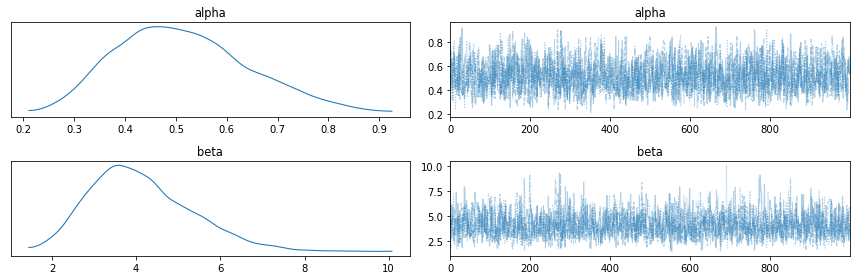

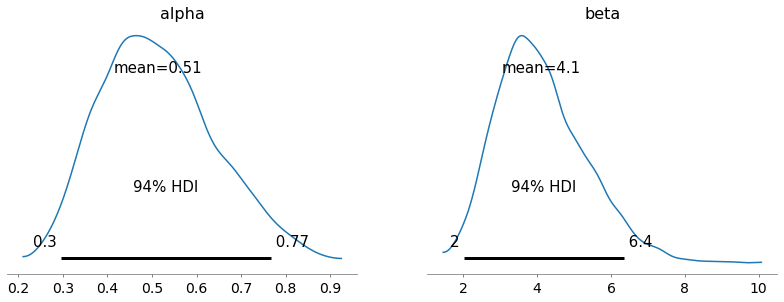

In [20]:
az.plot_trace(rw_model.traces['other']['558955ebfdf99b6bd06016c9'], var_names=['alpha', 'beta'], combined=True)
plt.tight_layout()
az.plot_posterior(rw_model.traces['other']['558955ebfdf99b6bd06016c9'], var_names=['alpha', 'beta'])

array([<AxesSubplot:title={'center':'alpha'}>,
       <AxesSubplot:title={'center':'beta'}>], dtype=object)

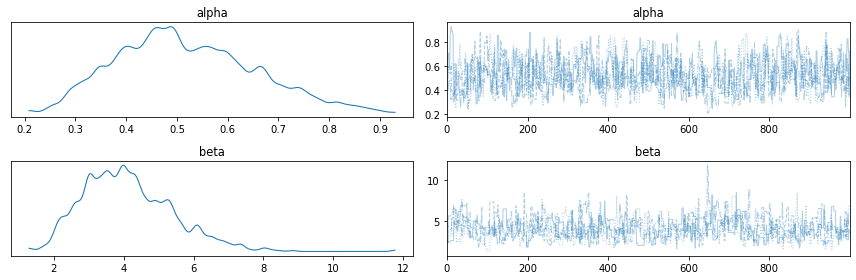

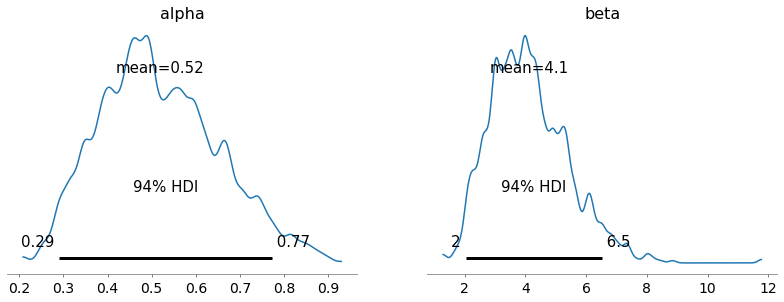

In [21]:
az.plot_trace(jointseqrw_model.traces['other']['558955ebfdf99b6bd06016c9'], var_names=['alpha', 'beta'], combined=True)
plt.tight_layout()
az.plot_posterior(jointseqrw_model.traces['other']['558955ebfdf99b6bd06016c9'], var_names=['alpha', 'beta'])

## Model comparison

In [22]:
waic_compare = az.compare({
    'jointseqrw': jointseqrw_model.traces['other']['558955ebfdf99b6bd06016c9'],
    'rw': rw_model.traces['other']['558955ebfdf99b6bd06016c9']
}, 
var_name='like',
ic='waic')
waic_compare

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
rw,0,-24.451826,1.248853,0.000000,1.0,4.315924,0.000000,False,log
jointseqrw,1,-24.580533,1.351490,0.128707,0.0,4.351652,0.042842,False,log


<AxesSubplot:xlabel='Log'>

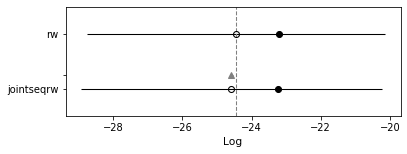

In [23]:
az.plot_compare(waic_compare)

In [24]:
jointseqrw_model.traces['other']['558955ebfdf99b6bd06016c9']

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [25]:
rw_model.traces['other']['558955ebfdf99b6bd06016c9']

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

## Heatmap of RW vs JointSeqRW parameter estimates

In [45]:
np.hstack(rw_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior.alpha.values).shape

(4000,)

/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


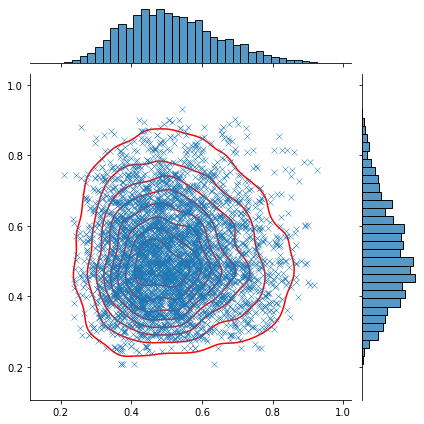

In [61]:
g = sns.jointplot(
    x=np.hstack(rw_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior.alpha.values),
    y=np.hstack(jointseqrw_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior.alpha.values),
    kind='scatter',
    marker='x',
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=9)


/Users/kulkarnik/miniconda3/envs/jupyter/lib/python3.8/site-packages/seaborn/relational.py:644: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


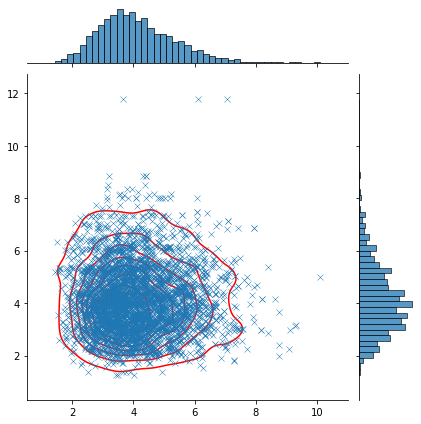

In [62]:
g = sns.jointplot(
    x=np.hstack(rw_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior.beta.values),
    y=np.hstack(jointseqrw_model.traces['other']['558955ebfdf99b6bd06016c9'].posterior.beta.values),
    kind='scatter',
    marker='x',
)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=9)